# Notes

- Pourquoi les ACF et PACF sont nulles après Box-Cox ?
- Transformation inverse et fitting ? Sur quoi ajuster le modèle final ?
- Est ce que les checkup_res sont bons ? Et comment interpréter le QQ-plot ?

In [2]:
import pandas as pd
import numpy as np
import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import locale
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import warnings

from checkup_res import checkup_res

warnings.filterwarnings("ignore")
locale.setlocale(locale.LC_TIME,'')
pd.options.plotting.backend = "plotly"

ModuleNotFoundError: No module named 'pmdarima'

In [ ]:
ts = pd.read_pickle("orders.pkl")
ts['2021-01-04':].to_csv("orders.csv")
train = ts['2021-01-04':'2021-10-10']
test = ts["2021-10-11":]

In [3]:
ts.plot(title=f'Nb. de commandes par jour de {ts.index[0].strftime("%d-%m-%Y")} au {ts.index[-1].strftime("%d-%m-%Y")}')

NameError: name 'ts' is not defined

La série décrit le nombre de commandes livrées par jour du 02 janvier 2020 au 15 octobre 2021 soit jours. On observe une forte saisonalité sur les jours de la semaine. Une modélisation par un modèle SARIMA peut être envisagé.

In [4]:
weekdays = ['lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche']
ts.groupby(ts.index.strftime("%A")).mean().reindex(weekdays).plot(title="Nb. moyen de commandes par jour")

Cependant, il est clair que la série n'est pas stationnaire car :
- il semble y avoir une tendance légèrement à la hausse.
- la série ne semble pas avoir une variance constante au cours du temps.

On tente dans un premier temps une décomposition classique :
$$ X_t = m_t + S_t + Z_t $$
tel que $m_t$ et $S_t$ sont déterministes et représentent respectivment une tendance et une composante 7-périodique. $Z_t$ est quand à lui un terme de fluctuation dont on souhaiterai qu'il contienne des dépendances.

In [5]:
decomp = seasonal_decompose(ts.n_orders, model='additive')
decomp.trend.plot()

In [6]:
decomp.resid.plot()

In [7]:
y = decomp.resid.dropna()

# ADF Test
result = adfuller(y, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# KPSS Test
result = kpss(y, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Ljung-Box Test
result = sm.stats.acorr_ljungbox(decomp.resid.dropna().values, lags=[30], return_df=False)
print('\nLjung-Box Statistic: %f' % result[0][0])
print('p-value: %f' % result[1][0])

ADF Statistic: -8.838788006261417
p-value: 1.6905240925166546e-14

KPSS Statistic: 0.020582
p-value: 0.100000

Ljung-Box Statistic: 1005.557188
p-value: 0.000000


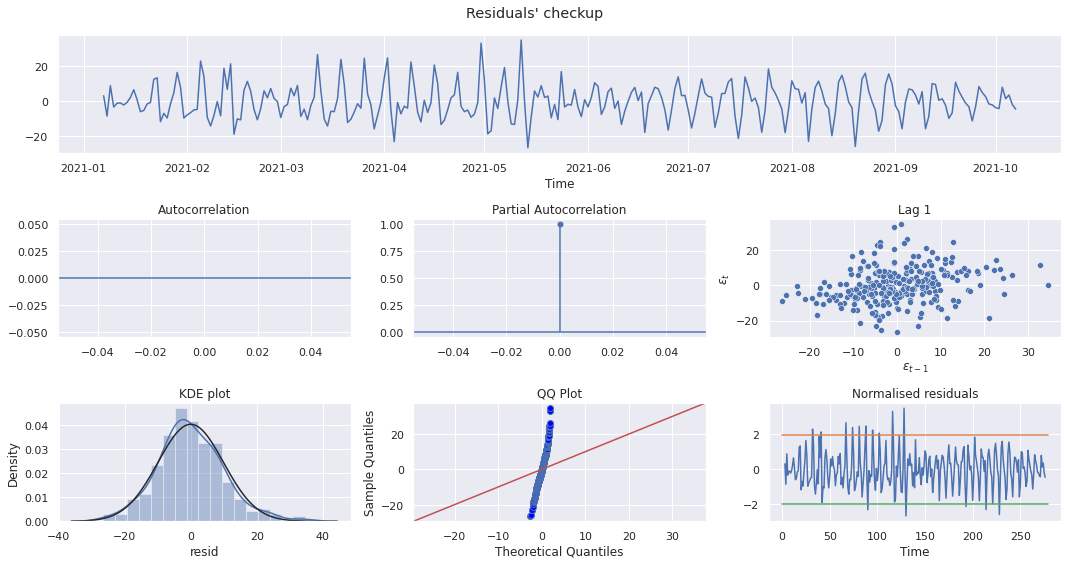

In [8]:
checkup_res(decomp.resid)

In [9]:
ts["log_n_orders"] = ts.n_orders
ts["log_n_orders"][ts.n_orders==0] = 1
ts["log_n_orders"] = np.log(ts.log_n_orders)
ts.plot()

In [10]:
decomp_log = decomp = seasonal_decompose(ts.log_n_orders, model='additive')
decomp_log.resid.plot()

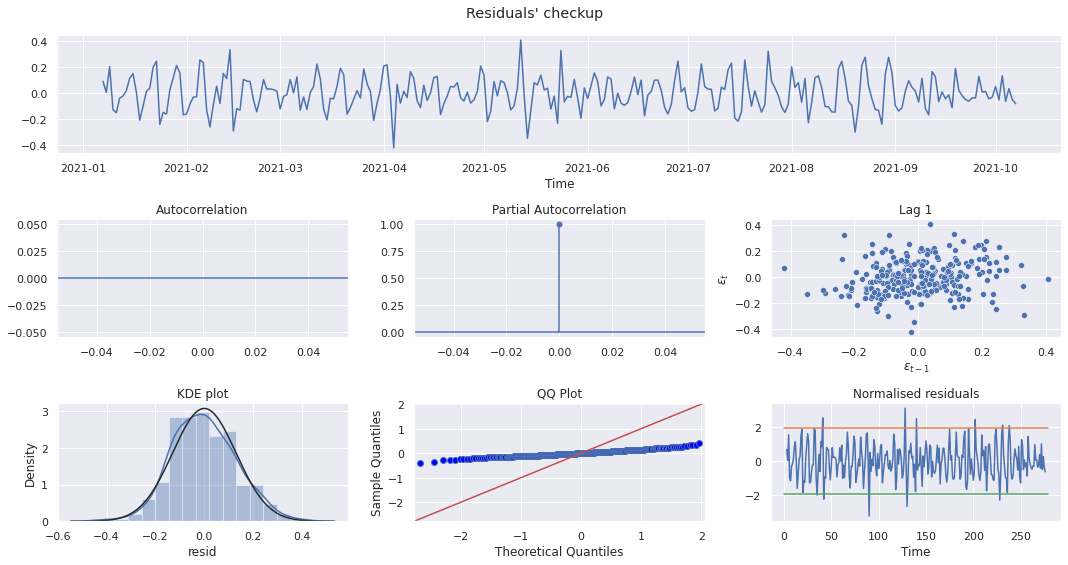

In [11]:
checkup_res(decomp_log.resid)

On observe une forte réduction de la variance.

The Box-Cox transformation is a family of power transformations indexed by a parameter lambda. Whenever you use it the parameter needs to be estimated from the data. In time series the process could have a non-constant variance. if the variance changes with time the process is nonstationary. It is often desirable to transform a time series to make it stationary. Sometimes after applying Box-Cox with a particular value of lambda the process may look stationary. It is sometimes possible that even if after applying the Box-Cox transformation the series does not appear to be stationary, diagnostics from ARIMA modeling can then be used to decide if differencing or seasonal differencing might be useful to remove polynomial trends or seasonal trends respectively. After that the result might be an ARMA model that is stationary. If diagnostics confirm the orders p and q for the ARMA model, the AR and MA parameters can then be estimated.

Regarding other possible uses of Box-Cox in the case of a series of iid random variables that do not appear to be normally distributed there may be a particular value of lambda that makes the data look approximately normal.

Presumably this could be applied in regression or time series to the error term.

maxlog=-0.7083349855859683


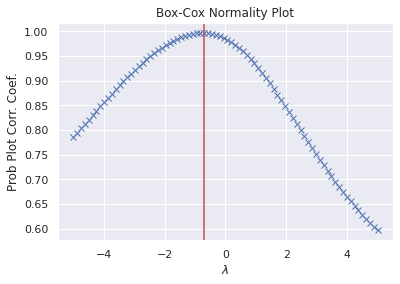

In [12]:
from scipy.stats import boxcox, boxcox_normplot
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
prob = boxcox_normplot(ts.n_orders, -20, 20, plot=ax)
_, maxlog = boxcox(ts.n_orders)
ax.axvline(maxlog, color='r')
print(f"{maxlog=}")

In [13]:
ts["boxcox_n_orders"] = boxcox(ts.n_orders, lmbda=maxlog)
ts.plot()

In [14]:
decomp_boxcox = seasonal_decompose(ts.boxcox_n_orders, model='additive')
decomp_boxcox.resid.plot()

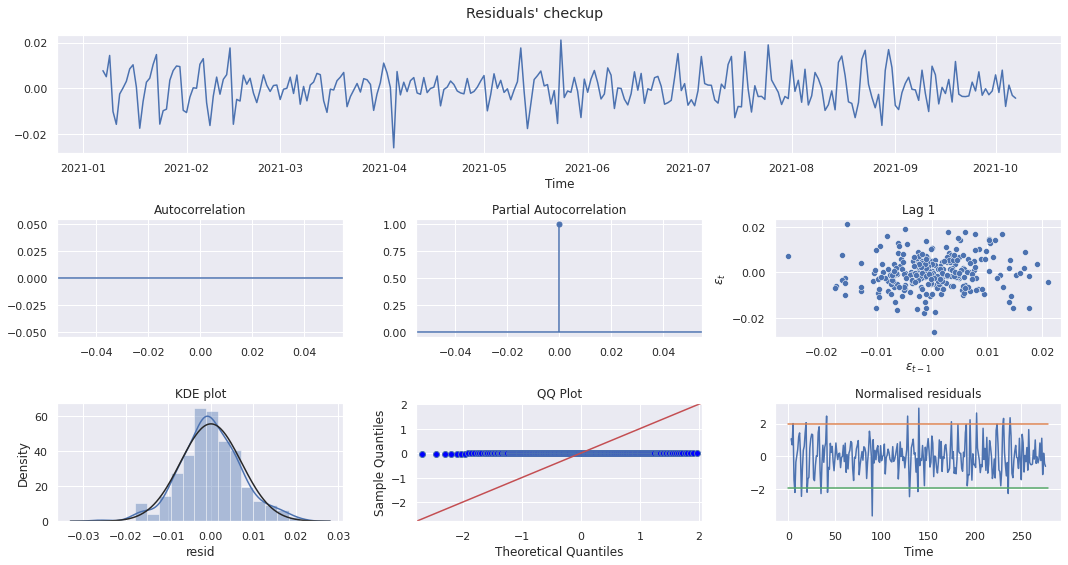

In [15]:
checkup_res(decomp_boxcox.resid)

In [16]:
decomp_boxcox.resid.dropna().values.shape

(274,)

In [17]:
import pmdarima as pm
y = decomp_boxcox.resid.dropna().values
model = pm.auto_arima(y,
                      start_p=1,
                      start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=7, max_q=2, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1925.576, Time=1.82 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1926.322, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1925.970, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1924.158, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1924.322, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 2.266 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  274
Model:                        SARIMAX   Log Likelihood                 964.161
Date:              jeu., 18 nov. 2021   AIC                          -1926.322
Time:                        18:12:24   BIC                          -1922.709
Sample:                             0   HQIC                         -1924.872
                                - 274                                  

In [21]:
y = ts.log_n_orders.values
model = pm.auto_arima(y,
                      X=None,
                      start_p=0,
                      start_q=0,
                      max_p=5,
                      max_d=2,
                      max_q=5,
                      start_P=0,
                      start_Q=0,
                      max_P=2,
                      max_D=1,
                      max_Q=2,
                      max_order=5,
                      m=7,
                      n_jobs=-1,
                      out_of_sample_size=28,
                      scoring='mse', 
                      with_intercept=True)

print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  280
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 7)   Log Likelihood                 183.813
Date:                           jeu., 18 nov. 2021   AIC                           -353.627
Time:                                     18:27:51   BIC                           -328.208
Sample:                                          0   HQIC                          -343.430
                                             - 280                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6799      0.091     -7.503      0.000      -0.858      -0.502
ar.L2          0.2929      

In [27]:
model.fit_predict

<bound method BaseARIMA.fit_predict of ARIMA(order=(2, 1, 2), out_of_sample_size=28, scoring_args={},
      seasonal_order=(1, 0, 1, 7), suppress_warnings=True,
      with_intercept=False)>

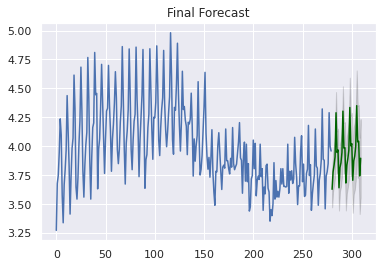

In [23]:
# Forecast
n_periods = 30
fc, confint = model.predict(n_periods=n_periods, alpha=0.2, return_conf_int=True)
index_of_fc = np.arange(len(y), len(y)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(y)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast")
plt.show()

Test RMSE: 0.151


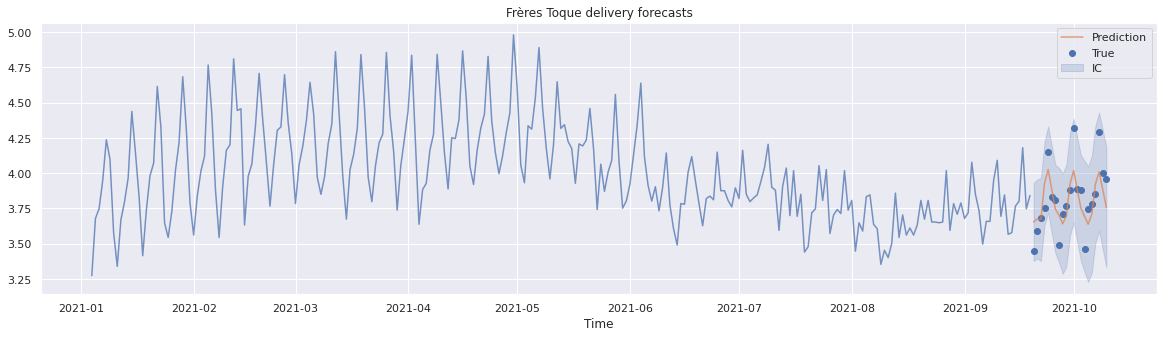

In [42]:
# #############################################################################
# Load the data and split it into separate pieces
train, test = model_selection.train_test_split(y, train_size=259)

# Fit a simple auto_arima model
modl = pm.auto_arima(train, start_p=0, start_q=0, max_d=1, start_P=0, start_Q=0,
                     max_p=5, max_q=5, max_P=1, max_Q=1, seasonal=True,
                     stepwise=True, suppress_warnings=True, max_D=1,
                     error_action='ignore')

# Create predictions for the future, evaluate on test
preds, conf_int = modl.predict(n_periods=test.shape[0], return_conf_int=True)

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

# #############################################################################
# Plot the points and the forecasts
plt.figure(figsize=(20, 5))
plt.plot(ts.index.values[:train.shape[0]], train, alpha=0.75)
plt.plot(ts.index.values[train.shape[0]:], preds, alpha=0.75, label="Prediction")
plt.scatter(ts.index.values[train.shape[0]:], test, marker="o", label="True")
plt.fill_between(ts.index.values[-preds.shape[0]:], conf_int[:, 0], conf_int[:, 1], alpha=0.2, color='b', label="IC")
plt.title("Frères Toque delivery forecasts")
plt.xlabel("Time")
plt.legend()

In [4]:
# #############################################################################
# Load the data and split it into separate pieces
y = train.n_orders.values
nb_week2pred = 3
train, test = model_selection.train_test_split(y, train_size=y.shape[0] - 7 * nb_week2pred)

# Fit a simple auto_arima model
modl = pm.auto_arima(train, start_p=0, start_q=0, max_d=1, start_P=0, start_Q=0,
                     max_p=5, max_q=5, max_P=1, max_Q=1, seasonal=True,
                     stepwise=True, suppress_warnings=True, max_D=1,
                     error_action='ignore', )
print(modl)
# Create predictions for the future, evaluate on test
preds, conf_int = modl.predict(n_periods=test.shape[0], return_conf_int=True)

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

# #############################################################################
# Plot the points and the forecasts
plt.figure(figsize=(20, 5))
plt.plot(ts.index.values[:train.shape[0]], train, alpha=0.75)
plt.plot(ts.index.values[train.shape[0]:], preds, alpha=0.75, label="Prediction")
plt.scatter(ts.index.values[train.shape[0]:], test, marker="o", label="True")
plt.fill_between(ts.index.values[-preds.shape[0]:], conf_int[:, 0], conf_int[:, 1], alpha=0.2, color='b', label="IC")
plt.title("Frères Toque delivery forecasts")
plt.xlabel("Time")
plt.legend()

NameError: name 'train' is not defined

Test RMSE: 12.382


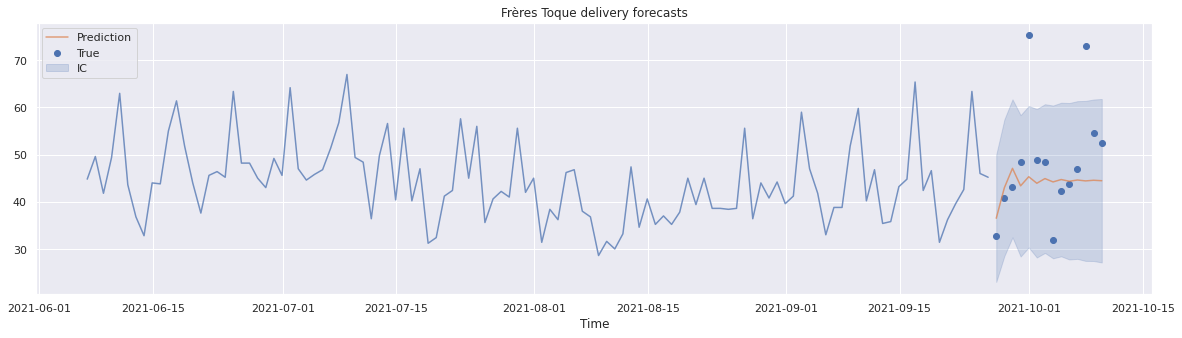

In [ ]:
# #############################################################################
# Load the data and split it into separate pieces
x = ts.iloc[-7*18:].index.values
y = ts.iloc[-7*18:].n_orders.values
nb_week2pred = 2
train, test = model_selection.train_test_split(y, train_size=y.shape[0] - 7 * nb_week2pred)

# Fit a simple auto_arima model
modl = pm.auto_arima(train, start_p=0, start_q=0, max_d=1, start_P=0, start_Q=0,
                     max_p=5, max_q=5, max_P=1, max_Q=1, seasonal=True,
                     stepwise=True, suppress_warnings=True, max_D=1,
                     error_action='ignore', )

# Create predictions for the future, evaluate on test
preds, conf_int = modl.predict(n_periods=test.shape[0], return_conf_int=True)

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

# #############################################################################
# Plot the points and the forecasts
plt.figure(figsize=(20, 5))
plt.plot(x[:train.shape[0]], train, alpha=0.75)
plt.plot(x[train.shape[0]:], preds, alpha=0.75, label="Prediction")
plt.scatter(x[train.shape[0]:], test, marker="o", label="True")
plt.fill_between(x[-preds.shape[0]:], conf_int[:, 0], conf_int[:, 1], alpha=0.2, color='b', label="IC")
plt.title("Frères Toque delivery forecasts")
plt.xlabel("Time")
plt.legend()